In [1]:
import tensorflow as tf
import numpy as np
import altair as alt
import pandas as pd
import matplotlib.pyplot as plt
from get_network import get_model, normalize
from regularized_explanations import ops, ig
from tqdm import tqdm
import scipy.misc

Using TensorFlow backend.


In [2]:
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed, mark_boundaries

In [3]:
model, sess = get_model()

In [4]:
image_op    = model.image_op
images_pl   = model.images_pl
labels_pl   = model.labels_pl
label_op    = model.label_op
logits      = model.logits
pred_labels = model.pred_labels
delta_pl = tf.placeholder(tf.float32, [None, 299, 299, 3])

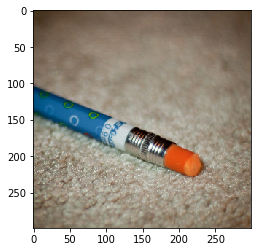

In [5]:
images = np.load('data/images.npy')
labels = np.load('data/labels.npy')
image_input = images[1]
label_input = labels[1]

image_input = np.expand_dims(image_input, axis=0)
label_input = np.expand_dims(label_input, axis=0)
plt.imshow(normalize(image_input[0]))

In [6]:
segmentation = np.load('data/segmentation.npy')

In [7]:
eraser_logit = logits[:, label_input[0]]

In [8]:
means_df = pd.read_csv('data/cluster_means.csv')

In [9]:
means_df = means_df[means_df['image_index'] == 1]

In [10]:
color_mask = np.zeros([299, 299, 3], dtype=np.int64)

In [11]:
for k in np.unique(segmentation[1]):
    selected_row = means_df.loc[means_df['cluster_index'] == k]
    color_mask[segmentation[1] == k, 0] = selected_row.loc[:, 'r'].values[0]
    color_mask[segmentation[1] == k, 1] = selected_row.loc[:, 'g'].values[0]
    color_mask[segmentation[1] == k, 2] = selected_row.loc[:, 'b'].values[0]

In [12]:
color_mask_float = normalize(color_mask, _domain=[0.0, 255.0], _range=[0.0, 1.0])

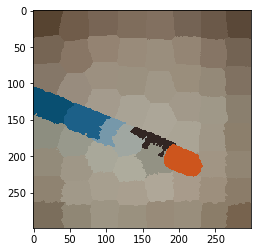

In [13]:
plt.imshow(color_mask_float)

In [14]:
scipy.misc.toimage(color_mask, cmin=0.0, cmax=1.0).save('data/slic_mask.png')

/home/psturm/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  """Entry point for launching an IPython kernel.


In [15]:
means_df = means_df.reset_index(drop=True)

In [16]:
def norm_clip(x):
    normalized = normalize(x.squeeze())
    clipped = np.clip(normalized, a_min=np.min(normalized), a_max=np.percentile(normalized, 99.9))
    return clipped

In [17]:
for index, row in means_df.iterrows():        
    selection_mask = np.zeros([299, 299], dtype=np.float32)
    
    k = row['cluster_index']
    r_map = np.ones([1, 299, 299, 1]) * row['r']
    g_map = np.ones([1, 299, 299, 1]) * row['g']
    b_map = np.ones([1, 299, 299, 1]) * row['b']
    reference_image = np.concatenate([r_map, g_map, b_map], axis=-1)
    input_reference = normalize(reference_image, _domain=[0.0, 255.0], _range=[-1.0, 1.0])
    display_reference = normalize(reference_image, _domain=[0.0, 255.0], _range=[0.0, 1.0])
    selection_mask[segmentation[1] == k] = 1
    
    alpha_mask = selection_mask * 0.8 + 0.2
    alpha_image = normalize(image_input.squeeze())
#     alpha_image[segmentation[1] == k, :] = color_mask_float[segmentation[1] == k, :]
#     alpha_image = np.concatenate([alpha_image, alpha_mask[:, :, np.newaxis]], axis=-1)
    alpha_image = mark_boundaries(alpha_image, selection_mask.astype(int), mode='thick')
    
    selected_slic_mask = color_mask_float
#     selected_slic_mask = np.concatenate([selected_slic_mask, alpha_mask[:, :, np.newaxis]], axis=-1)
    selected_slic_mask = mark_boundaries(selected_slic_mask, selection_mask.astype(int), mode='thick')
    
    explainer = ig.IGExplainer((images_pl, eraser_logit), data=display_reference)
    ig_weights = explainer.shap_values(image_input)
    abs_ig_weights = np.abs(ig_weights)
    sum_abs_ig_weights = np.sum(abs_ig_weights, axis=-1)
    ig_im = norm_clip(sum_abs_ig_weights.squeeze())
    
    scipy.misc.toimage(display_reference.squeeze(), cmin=0.0, cmax=1.0).save('data/ig_weights_slic/references/reference_{}.png'.format(k))
    scipy.misc.toimage(selected_slic_mask.squeeze(), cmin=0.0, cmax=1.0).save('data/ig_weights_slic/masks/slic_mask_{}.png'.format(k))
    scipy.misc.toimage(alpha_image.squeeze(), cmin=0.0, cmax=1.0).save('data/ig_weights_slic/images/slic_image_{}.png'.format(k))
    scipy.misc.toimage(ig_im.squeeze()).save('data/ig_weights_slic/ig_weights/ig_weights_{}.png'.format(k))
#     fig, axs = plt.subplots(1, 4, figsize=(20, 5))
#     axs[0].imshow(display_reference.squeeze())
#     axs[1].imshow(selected_slic_mask)
#     axs[2].imshow(alpha_image)
#     axs[3].imshow(ig_im, cmap='gray')
#     break

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0


100%|██████████| 200/200 [00:00<00:00, 459.81it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:06<00:00,  2.00s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



/home/psturm/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
/home/psturm/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
/home/psturm/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
/home/psturm/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
100%|██████████| 200/200 [00:00<00:00, 

Computing gradients for sample 0



100%|██████████| 4/4 [00:05<00:00,  1.59s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 462.81it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:05<00:00,  1.58s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 468.64it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:05<00:00,  1.63s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 480.48it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:05<00:00,  1.75s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 479.87it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:05<00:00,  1.75s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 479.06it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:06<00:00,  1.82s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 480.79it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:06<00:00,  1.96s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 480.37it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:06<00:00,  1.95s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 482.96it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:06<00:00,  2.03s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 481.33it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:07<00:00,  2.20s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 475.90it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:07<00:00,  2.20s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 478.41it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:07<00:00,  2.30s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 471.36it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:07<00:00,  2.40s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 484.01it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:07<00:00,  2.48s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 479.67it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:08<00:00,  2.69s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 478.50it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:08<00:00,  2.70s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 474.99it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:08<00:00,  2.81s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 468.10it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:09<00:00,  2.93s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 464.32it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:09<00:00,  3.04s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 479.94it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:09<00:00,  3.16s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 483.17it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:10<00:00,  3.39s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 483.08it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:10<00:00,  3.41s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 464.11it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:11<00:00,  3.54s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 464.78it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:11<00:00,  3.67s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 461.25it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:11<00:00,  3.80s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 483.56it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:12<00:00,  3.96s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 480.26it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:12<00:00,  4.11s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 459.48it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:13<00:00,  4.37s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 478.93it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:13<00:00,  4.41s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 473.94it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:14<00:00,  4.56s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 462.96it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:14<00:00,  4.74s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 478.09it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:15<00:00,  4.92s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 466.16it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:15<00:00,  5.08s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 471.30it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:16<00:00,  5.26s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 472.11it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:16<00:00,  5.50s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 476.93it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:17<00:00,  5.67s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

Received data of shape: (1, 299, 299, 3)


Evaluating points for sample 0


100%|██████████| 200/200 [00:00<00:00, 481.35it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:18<00:00,  6.04s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

Received data of shape: (1, 299, 299, 3)
Evaluating points for sample 0



100%|██████████| 200/200 [00:00<00:00, 483.33it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:18<00:00,  6.07s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

Received data of shape: (1, 299, 299, 3)


Evaluating points for sample 0


100%|██████████| 200/200 [00:00<00:00, 479.75it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:19<00:00,  6.30s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

Received data of shape: (1, 299, 299, 3)


Evaluating points for sample 0


100%|██████████| 200/200 [00:00<00:00, 479.77it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:19<00:00,  6.55s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

Received data of shape: (1, 299, 299, 3)


Evaluating points for sample 0


100%|██████████| 200/200 [00:00<00:00, 478.56it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:20<00:00,  6.77s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

Received data of shape: (1, 299, 299, 3)


Evaluating points for sample 0


100%|██████████| 200/200 [00:00<00:00, 478.61it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:21<00:00,  7.08s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

Received data of shape: (1, 299, 299, 3)


Evaluating points for sample 0


100%|██████████| 200/200 [00:00<00:00, 482.01it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:22<00:00,  7.30s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

Received data of shape: (1, 299, 299, 3)


Evaluating points for sample 0


100%|██████████| 200/200 [00:00<00:00, 476.03it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:22<00:00,  7.53s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

Received data of shape: (1, 299, 299, 3)


Evaluating points for sample 0


100%|██████████| 200/200 [00:00<00:00, 477.80it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:23<00:00,  7.79s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

Received data of shape: (1, 299, 299, 3)


Evaluating points for sample 0


100%|██████████| 200/200 [00:00<00:00, 479.02it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:24<00:00,  7.99s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

Received data of shape: (1, 299, 299, 3)


Evaluating points for sample 0


100%|██████████| 200/200 [00:00<00:00, 473.43it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:24<00:00,  8.26s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

Received data of shape: (1, 299, 299, 3)


Evaluating points for sample 0


100%|██████████| 200/200 [00:00<00:00, 466.18it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:26<00:00,  8.79s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

Received data of shape: (1, 299, 299, 3)


Evaluating points for sample 0


100%|██████████| 200/200 [00:00<00:00, 477.78it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:26<00:00,  8.87s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

Received data of shape: (1, 299, 299, 3)


Evaluating points for sample 0


100%|██████████| 200/200 [00:00<00:00, 479.69it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:28<00:00,  9.45s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

Received data of shape: (1, 299, 299, 3)


Evaluating points for sample 0


100%|██████████| 200/200 [00:00<00:00, 475.07it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:30<00:00, 10.23s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

Received data of shape: (1, 299, 299, 3)


Evaluating points for sample 0


100%|██████████| 200/200 [00:00<00:00, 478.97it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:32<00:00, 10.81s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

Received data of shape: (1, 299, 299, 3)


Evaluating points for sample 0


100%|██████████| 200/200 [00:00<00:00, 479.95it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:33<00:00, 11.19s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

Received data of shape: (1, 299, 299, 3)


Evaluating points for sample 0


100%|██████████| 200/200 [00:00<00:00, 478.61it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:34<00:00, 11.67s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

Received data of shape: (1, 299, 299, 3)


Evaluating points for sample 0


100%|██████████| 200/200 [00:00<00:00, 480.05it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:36<00:00, 12.10s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

Received data of shape: (1, 299, 299, 3)


Evaluating points for sample 0


100%|██████████| 200/200 [00:00<00:00, 478.70it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:36<00:00, 12.40s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

Received data of shape: (1, 299, 299, 3)


Evaluating points for sample 0


100%|██████████| 200/200 [00:00<00:00, 456.05it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:38<00:00, 12.96s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

Received data of shape: (1, 299, 299, 3)


Evaluating points for sample 0


100%|██████████| 200/200 [00:00<00:00, 475.57it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:39<00:00, 13.33s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

Received data of shape: (1, 299, 299, 3)


Evaluating points for sample 0


100%|██████████| 200/200 [00:00<00:00, 465.97it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:40<00:00, 13.65s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

Received data of shape: (1, 299, 299, 3)


Evaluating points for sample 0


100%|██████████| 200/200 [00:00<00:00, 477.01it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:41<00:00, 13.98s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

Received data of shape: (1, 299, 299, 3)


Evaluating points for sample 0


100%|██████████| 200/200 [00:00<00:00, 481.46it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:42<00:00, 14.44s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

Received data of shape: (1, 299, 299, 3)


Evaluating points for sample 0


100%|██████████| 200/200 [00:00<00:00, 481.27it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:44<00:00, 15.15s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

Received data of shape: (1, 299, 299, 3)


Evaluating points for sample 0


100%|██████████| 200/200 [00:00<00:00, 479.15it/s]

Computing gradients for sample 0



100%|██████████| 4/4 [00:45<00:00, 15.36s/it]

Computing attributions for sample 0



100%|██████████| 1/1 [00:00<00:00,  1.96it/s]
